# FIRE - Far-ultraviolet Irradiated Rotational Evolution model

## Disk dissipation timescales as a function of Far-ultraviolet fluxes

**Last update (Julia Roquette - 3rd August 2021):** Added to github. 

The package `spin.FUVfunctions` contains a series of functions related to the explorations of how the FUV flux from massive stars influences their environments. A second notebook, `MassiveStarsNeighbourhood.ipynb`,  describes the `spin.FUVfunctions.Parravano` class. Here I described the tools used to read and use the Winter et al. 2020<sup id="N1">[[1]](#f1)</sup> disk dissipation models. 

<b id="N1">[1]</b> [Winter et
    al. (2020) MNRAS 491 90](https://ui.adsabs.harvard.edu/abs/2020MNRAS.491..903W/abstract)


First of all, the package includes a colour-table that I have been using for mapping the FUV-fluxes.

In [1]:
from fire.FUVfunctions import cmapFUV, normFUV, plotCmapFUV

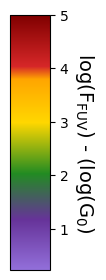

In [2]:
plotCmapFUV()

Next, this part of the code initialises the `class` called `DiskWithFUV`, which reads the Winter+2020 models. 

The usage is:

```python
disk = fire.FUVfunctions.DiskWithFUV()
````

And in the initialisation, it loads `disk.M` and `disk.FUV`, which gives masses (in M$_\odot$) and FUV fluxes (in G$_0$) for which the models are available. `disk.WFC20` returns an `astropy` table with all Winter+2020 models. 


```python 
class DiskWithFUV:
    """
    Interpolates timescales for disk dissipation as a function of the local
    FUV flux, base on the results of the disk-dissipation model by Winter et
    al. (2020) MNRAS 491 90
    https://ui.adsabs.harvard.edu/abs/2020MNRAS.491..903W/abstract
    
    WKC20 grid provides: 
        - tauvisc_Myr
        - Mstar_Msol
        - FUV_G0
        - Mdisc_Msol
        - Rscale_au
        - alphavisc
        - Tdisp_Myr
    
    -----
    Version: 14th July 2021
    
    
    
                - input - 
    mass: in Msun
    FUV:  in Go
    tau_vis=1. is the recommended value by Andrew Winter
    curves: default=False
    ---
    - output- 
    if curves=False, returns tau_d which is the timescale for 
        disk-dissipation by external photoevaporation under FUV
    if curves=True, returns a curve of FUV,tau_d for the mass given
         
    """
    def __init__(self):
        """
        Load tabulations for a fixed viscous timescales as a grid
        
        --- 
        Usage:
            
            disk_model=DiskWithFUV()

        """
        import os
        datadir = os.path.join(os.path.dirname(os.path.abspath(__file__)),
                           'data/disk_model/WKC20/')     
        self.WKC20 = Table.read(datadir + 
                                'FUVdisp_R40_tauvisc.csv', format='csv')
        #masses for  which disk-models are calculated
        self.M = np.array([0.1, 0.3, 0.5, 0.8, 1., 1.3, 1.6, 1.9]) 
        self.FUV = np.unique(np.array(self.WKC20['FUV_G0']))
```

The function `disk.get_tauD_vs_FUV(mass, tau_vis=viscous timescale)` will define the objects `disk.tauD_Myr`, which has the same dimension as `disk.FUV` and gives the disk dissipation timescales for each FUV-level for the given mass and viscous timescales. The models are available for viscous timescales of 1, 2 and 5 Myrs. 

```python 

    def get_tauD_vs_FUV(self, mass, tau_vis=1.):
        """
        Select within the grid the tabulations for a mass and and 
        viscous timescale
        
        ____
        input:
            mass = mass in Msun 
            tau_vis [1.0,2.0,5.0] = viscous timescale in Myrs
        
        """
        self.mass = mass #needs to keep track to know where I am in the grid
        select_tau_vis = self.WKC20['# tauvisc_Myr'] == tau_vis   
        if mass in self.M: #just select table for the M and interpolate values
            select_mass = self.WKC20['Mstar_Msol'] == mass
            self.tauD_Myr = 1e6*np.array(self.WKC20['Tdisp_Myr'][select_mass \
                                                    & select_tau_vis])
        elif (mass > self.M.max()) or (mass < self.M.min()):
            print('outside mass limit')
            self.tauD_Myr = np.full(len(self.FUV), np.nan)
        else: # interpolate a new table
            j = np.argsort(abs(self.M - mass))[0]
            if self.M[j] > mass:
                x = [self.M[j - 1], self.M[j]]
            else:
                x = [self.M[j], self.M[j + 1]]
            self.tauD_Myr = \
               np.array([1e6*np.interp(mass, x, y) for y in list(zip(\
                               self.WKC20['Tdisp_Myr'][select_tau_vis & 
                               (self.WKC20['Mstar_Msol'] == x[0])],  
                               self.WKC20['Tdisp_Myr'][select_tau_vis & 
                               (self.WKC20['Mstar_Msol'] ==  x[1])]))])
```

The function `disk.get_tauD(mass, FUV, tau_vis=viscous timescale)` will _return_ the disk dissipation timescale for a star of given mass and viscous timescale evolving under a given FUV flux. Note that this function _returns_ a value in years rather than creating an object, and it can be used independently from the `disk.get_tauD_vs_FUV`.


```python
    def get_tauD(self, mass, FUV, tau_vis=1.):
        self.get_tauD_vs_FUV(mass, tau_vis=tau_vis)
        if FUV in self.FUV: 
            return self.tauD_Myr[self.FUV == FUV][0]
        elif FUV > 1e4:
            return self.tauD_Myr[self.FUV == 1e4][0]
        elif FUV > 0:
            return 10**interp1d(np.log10(self.FUV),np.log10(self.tauD_Myr), 
                                kind='linear', bounds_error=False, 
                                fill_value='extrapolate')(np.log10(FUV))
        else: 
            return 10**interp1d(np.log10(self.FUV),np.log10(self.tauD_Myr), 
                                kind='linear', bounds_error=False, 
                                fill_value='extrapolate')(np.log10(1e-10))
```

## $\tau_\mathrm{SDI}$ as a function of FUV-flux, mass and $\tau_\rm{vis}$

In [3]:
from fire.FUVfunctions import DiskWithFUV

In [4]:
disk = DiskWithFUV()

In [5]:
disk.M

array([0.1, 0.3, 0.5, 0.8, 1. , 1.3, 1.6, 1.9])

In [6]:
disk.FUV

array([   10.,   100.,  1000.,  5000., 10000.])

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

<ipython-input-8-3993d7c81585>:48: RuntimeWarning: overflow encountered in power
  return 10**x


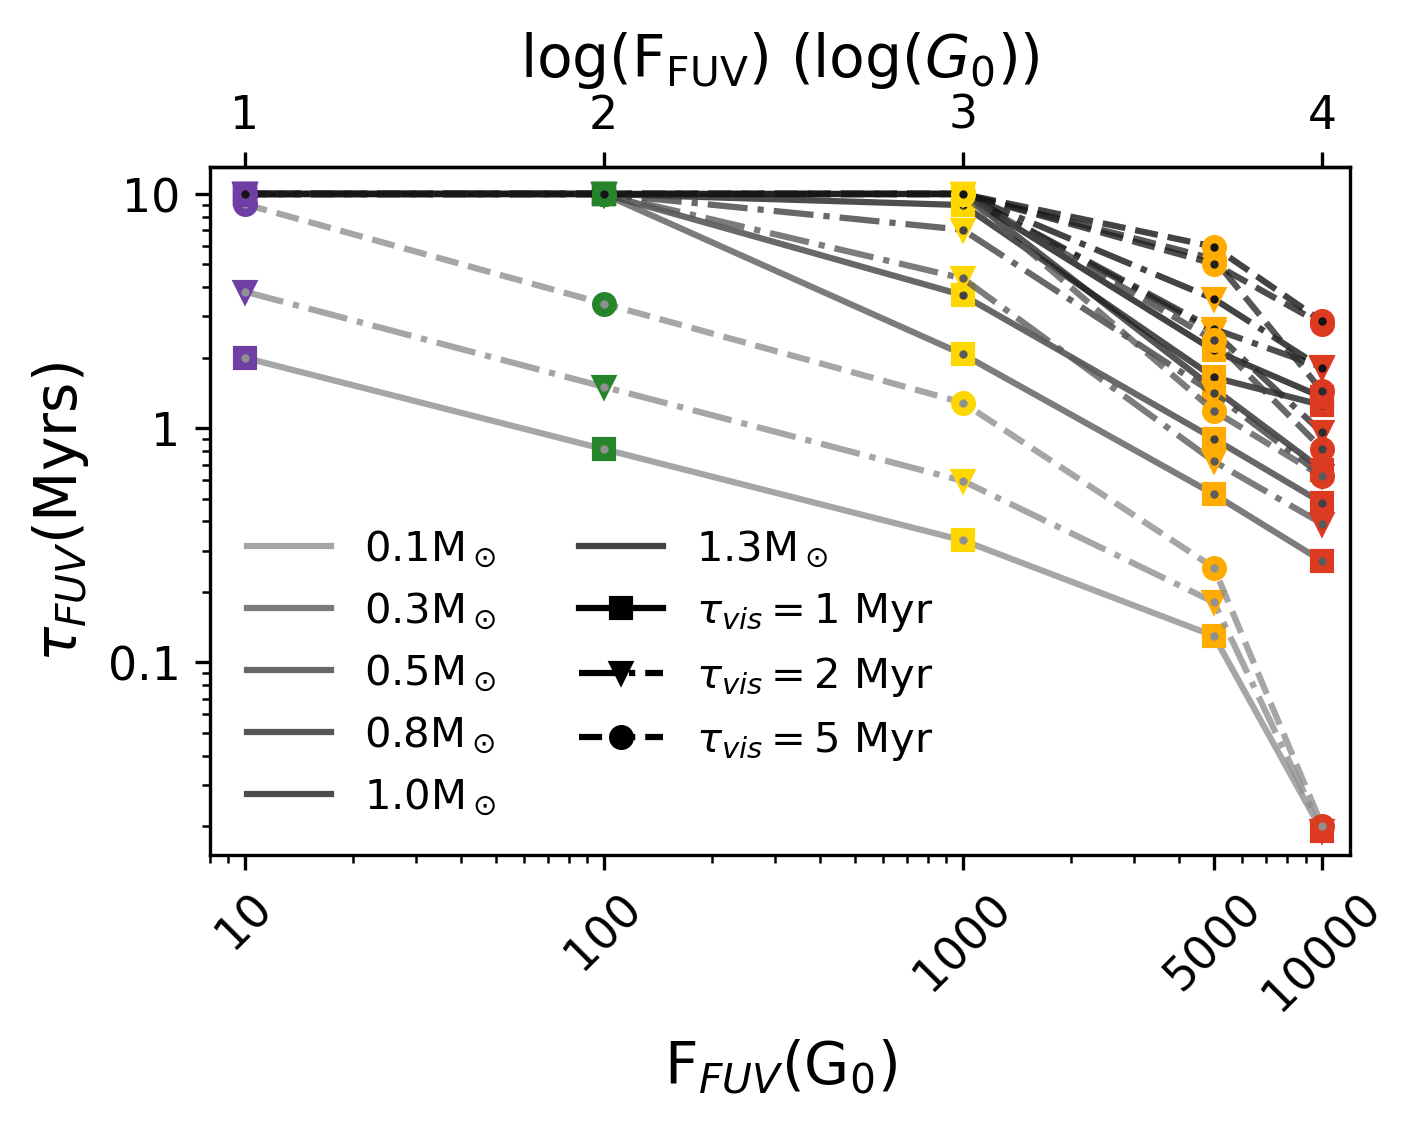

In [8]:
cmap_M=plt.get_cmap('binary')
norm_M=mpl.colors.LogNorm(0.01,2.)
fs=14
#
fig = plt.subplots(figsize=(4.5, 3.7), dpi=300)
plt.subplots_adjust(left=0.13, right=0.975, bottom=0.23, top=0.85)
ax = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)
alpha = 0.8
lw = ['-', '-.', '--']
sy = ['s', 'v', 'o']
zor = [0, 1, 2]
for k, tau_vis in enumerate([1, 2, 5]):
    for i, Mstar in enumerate(disk.M[:-2]):
        disk.get_tauD_vs_FUV(Mstar, tau_vis=tau_vis)
        if k == 0:
            ax.plot(disk.FUV, disk.tauD_Myr/1e6, lw[k], 
                    color=cmap_M(norm_M(Mstar)), 
                    label=str(Mstar) + r'M$_\odot$', alpha=alpha, 
                    zorder=zor[k])
        else: 
            ax.plot(disk.FUV, disk.tauD_Myr/1e6, lw[k], 
                    color=cmap_M(norm_M(Mstar)), alpha=alpha, zorder=zor[k])
        for j,fuv in enumerate(disk.FUV):
            ax.plot(fuv, disk.tauD_Myr[j]/1e6, sy[k], 
                    color=cmapFUV(normFUV(np.log10(fuv))), ms=5, 
                    zorder=zor[k])
        ax.plot(disk.FUV, disk.tauD_Myr/1e6, '.', color=cmap_M(norm_M(Mstar)),
                ms=2, zorder=zor[k])     

        ax.set_xlim(8, 1.2e4)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel(r'F$_{FUV}$(G$_0$)', fontsize=fs)    
ax.set_ylabel(r'$\tau_{FUV}$(Myrs)', fontsize=fs)
ax.set_yticks([0.1, 1, 10])
ax.set_yticklabels([0.1, 1, 10], fontsize=fs - 3) 
ax.set_xticks([10, 100, 1000, 5000, 10000])
ax.set_xticklabels([10, 100, 1000, 5000, 10000], fontsize=fs - 3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_ylim(0.015, 13)
ax.set_xlim(8, 12000)
for j, t in enumerate([1, 2, 5]):
    ax.plot(-10, -10, sy[j], color='k', ms=5, zorder=zor[k], 
            label=r'$\tau_{vis}=$' + str(int(t)) + ' Myr',
            linestyle=lw[j])
#This functions are used for defining a secondary axis on the top
def power10(x):
    return 10**x
def log10(x):
    return np.log10(x)
ax_ = ax.secondary_xaxis("top", functions=(log10, power10))
ax_.set_xlabel(r'$\log(\mathrm{F}_\mathrm{FUV})$ ($\log(G_0)$)', fontsize=fs)
ax_.set_xticks([1, 2, 3, 4])
ax_.set_xticklabels([1, 2, 3, 4], fontsize=fs - 3)

leg = ax.legend(ncol=2)
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_facecolor('none')
#uncomment to save plots
#plt.savefig('/your directory/testingAndrewsTabulations_tauvis_1_2_5.png')

In [9]:
t_fuv = np.full((len(disk.M[:-2]), len(disk.FUV), 3), np.nan)
for k, tauv in enumerate([1, 2, 5]):
    for i, m in enumerate(disk.M[:-2]):
        disk.get_tauD_vs_FUV(m, tau_vis=tauv) 
        t_fuv[i, :, k] = disk.tauD_Myr/1e6

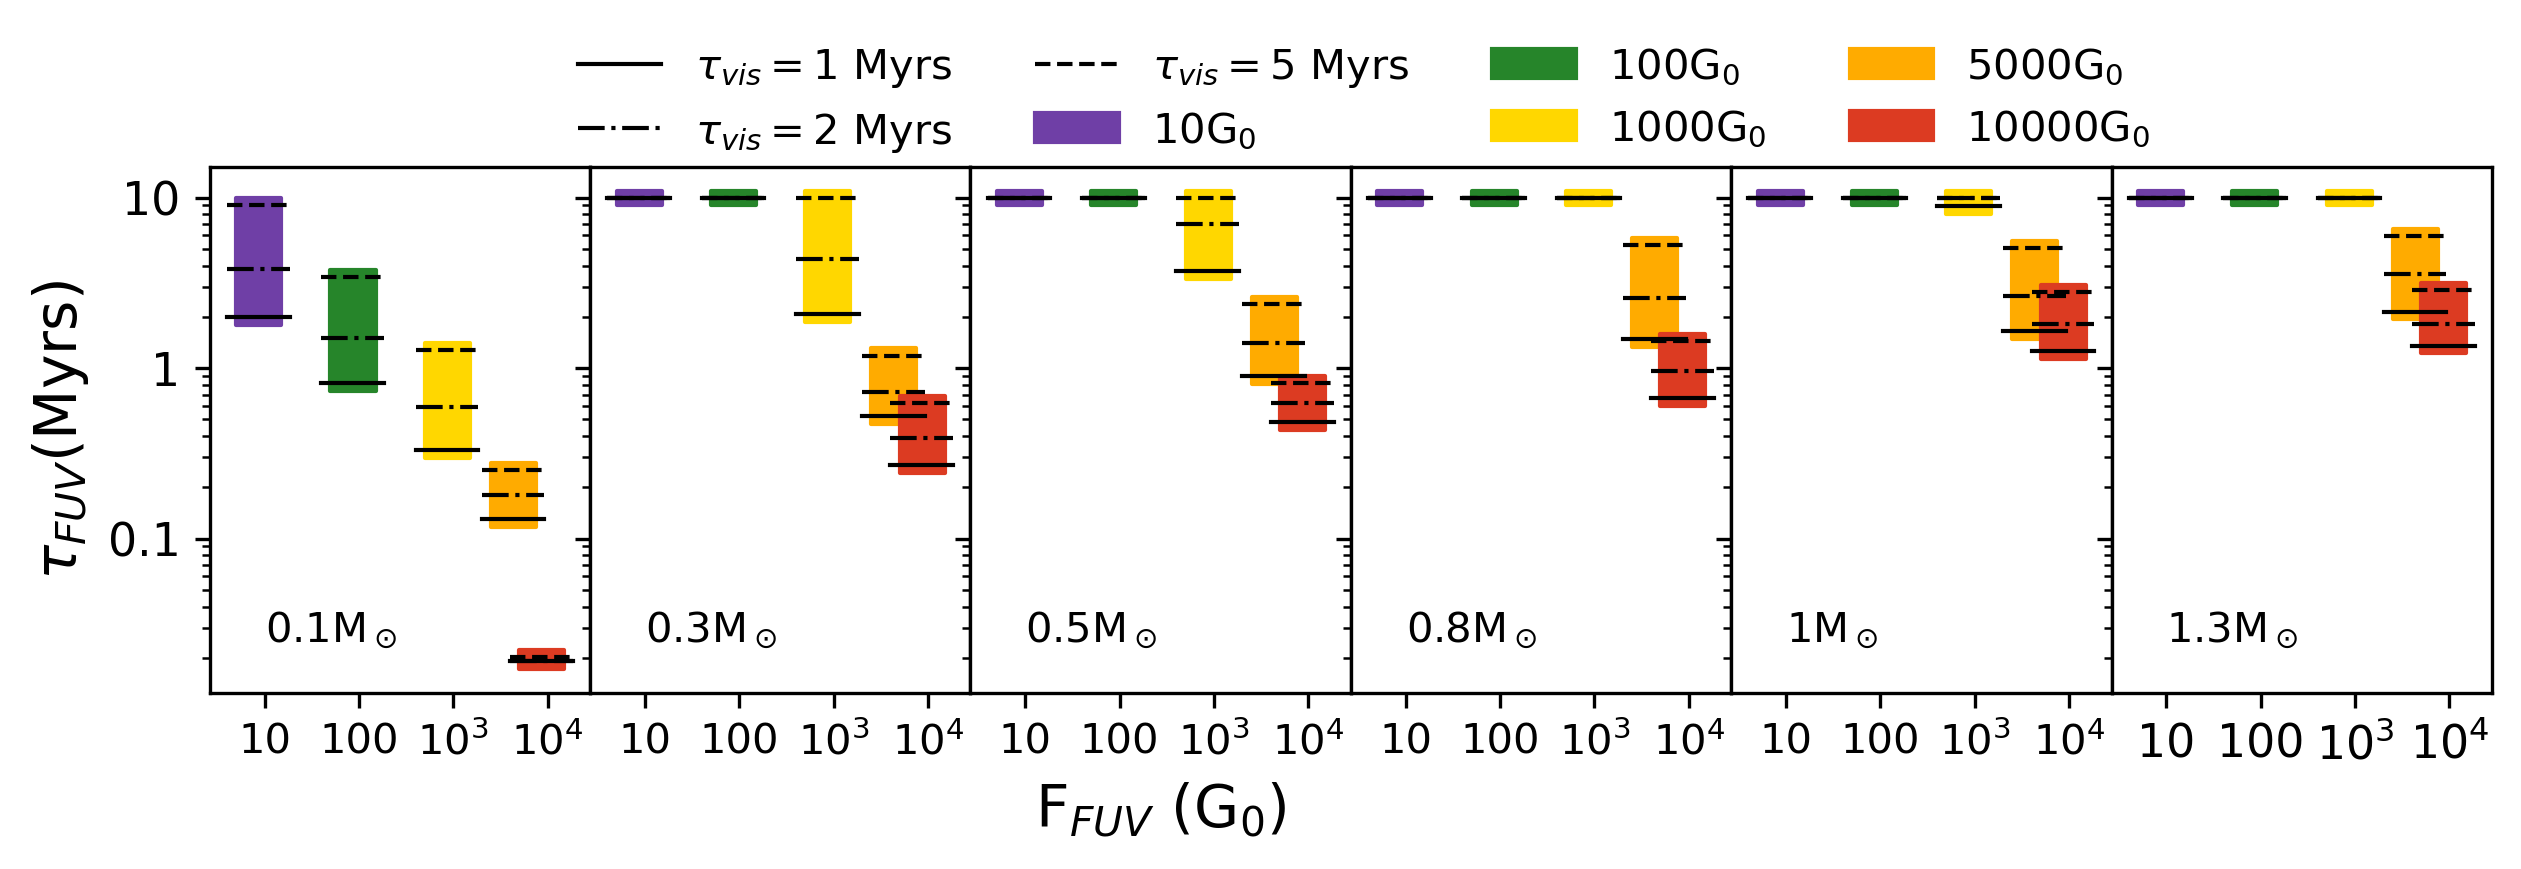

In [11]:
fig, axis = plt.subplots(1, 6, figsize=(8.5, 2.7), dpi=300, sharex=True, 
                         sharey=True)
plt.subplots_adjust(left=0.09, right=0.985, bottom=0.2, top=0.85)
plt.subplots_adjust(wspace=0., hspace=0)
dx=[5, 50, 500, 2500, 5000]
fs = 14
axis[0].set_xscale("log")
axis[0].set_yscale("log")
axis[0].set_yticks([0.1, 1, 10])
axis[0].set_yticklabels([0.1, 1, 10], fontsize=fs - 3)
tauvis = [1, 2, 5]
ls = ['-', '-.', '--']
n = 0
wb = 0.1
for i, m in enumerate(disk.M[:-2]):
    ax = axis[i]    
    if m == 1:
        ax.text(10, 0.025, str(int(m)) + r'M$_\odot$')
    else:
        ax.text(10, 0.025, str(m) + r'M$_\odot$')
    for j, fuv in enumerate(disk.FUV):
        if i == 0:
            ax.fill_between([fuv - dx[j], fuv + dx[j]], 
                     [t_fuv[i, j].min()*(1 - wb), t_fuv[i, j].min()*(1 - wb)],
                     [t_fuv[i, j].max()*(1 + wb), t_fuv[i, j].max()*(1 + wb)],
                            color=cmapFUV(normFUV(np.log10(fuv))), 
                            zorder=j, label=str(int(fuv)) + r'G$_0$')
        else:
            ax.fill_between([fuv - dx[j], fuv + dx[j]], 
                     [t_fuv[i, j].min()*(1 - wb), t_fuv[i, j].min()*(1 - wb)],
                     [t_fuv[i, j].max()*(1 + wb), t_fuv[i, j].max()*(1 + wb)],
                        color=cmapFUV(normFUV(np.log10(fuv))), zorder=j)                
        for k, tv in enumerate([1., 2., 5]):
            if n == 0:
                ax.plot([fuv - dx[j]*1.2, fuv + dx[j]*1.7], [t_fuv[i, j, k], 
                       t_fuv[i, j, k]], ls[k], color='k', lw=1, zorder=10 + k,
                        label=r'$\tau_{vis}=$' + str(tauvis[k]) + ' Myrs') 
            else:
                ax.plot([fuv - dx[j]*1.2, fuv + dx[j]*1.7], [t_fuv[i, j, k], 
                    t_fuv[i, j, k]], ls[k], color='k', lw=1, zorder=10 + k) 
        n += 1
axis[2].set_xlabel(r'F$_{FUV}$ (G$_0$)', fontsize=fs)    
axis[0].set_ylabel(r'$\tau_{FUV}$(Myrs)', fontsize=fs)



ax.set_xticks([10, 100, 1000, 10000])
ax.set_xticklabels([10, 100, r'10$^3$', r'10$^4$'], fontsize=fs - 3)
leg = axis[0].legend(ncol=4, bbox_to_anchor=(5.2, 1.3))
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_facecolor('none')
plt.savefig('/Users/jroquette/work/plot/testingAndrewsTabulations_tauvis_1_2_5_mass.png')

This is plot in the paper:

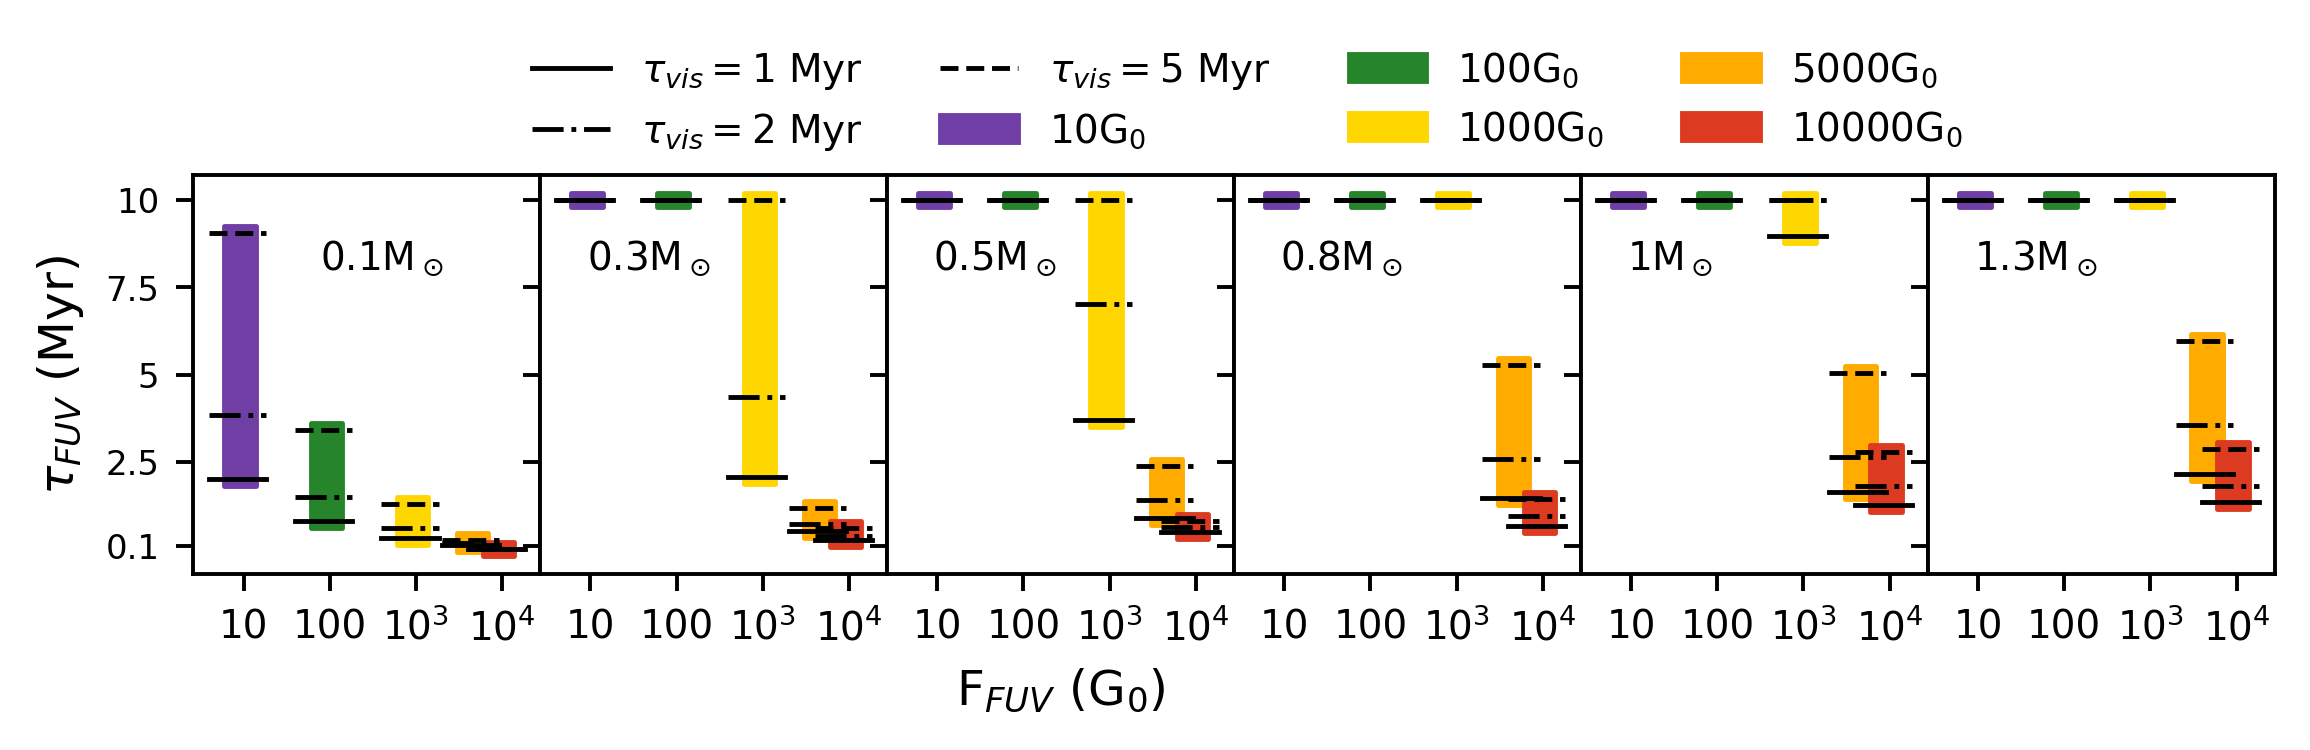

In [12]:
fig, axis = plt.subplots(1, 6, figsize=(6.5, 2), dpi=350, sharex=True, 
                         sharey=True)
plt.subplots_adjust(left=0.08, right=0.995, bottom=0.23, top=0.8)
plt.subplots_adjust(wspace=0., hspace=0)
wb_ = 4
dx = wb_*np.array([1, 10, 100, 1000/2., 1000])
fs = 10
axis[0].set_xscale("log")
axis[0].set_yticks([0.1, 2.5, 5, 7.5, 10])
axis[0].set_yticklabels([0.1, 2.5, 5, 7.5, 10], fontsize=fs - 3) 
tauvis = [1, 2, 5]
wb = 0.2
ls = ['-', '-.', '--']
n = 0
for i, m in enumerate(disk.M[:-2]):
    ax = axis[i]    
    if m == 1:
        ax.text(9, 8, str(int(m)) + r'M$_\odot$', fontsize=fs - 2)
    elif m == 0.1:
        ax.text(78, 8, str(m) + r'M$_\odot$', fontsize=fs - 2) 
    else:
        ax.text(9, 8, str(m) + r'M$_\odot$', fontsize=fs - 2)
    for j, fuv in enumerate(disk.FUV):
        if i == 0:
            ax.fill_between([fuv - dx[j], fuv + dx[j]], 
                            [t_fuv[i, j].min() - wb, t_fuv[i, j].min() - wb], 
                            [t_fuv[i, j].max() + wb, t_fuv[i, j].max() + wb],
                            color=cmapFUV(normFUV(np.log10(fuv))), 
                            zorder=j, label=str(int(fuv)) + r'G$_0$')
        else:
            ax.fill_between([fuv - dx[j], fuv + dx[j]], 
                            [t_fuv[i, j].min() - wb, t_fuv[i, j].min() - wb],
                            [t_fuv[i, j].max() + wb, t_fuv[i, j].max() + wb],
                            color=cmapFUV(normFUV(np.log10(fuv))), zorder=j)    
                
        for k, tv in enumerate([1., 2., 5]):
            if n == 0:
                ax.plot([fuv - dx[j]*1.5, fuv + dx[j]*2.1], [t_fuv[i, j, k], 
                        t_fuv[i, j, k]], ls[k], color='k', lw=1, zorder=10 + k, 
                        label=r'$\tau_{vis}=$' + str(tauvis[k]) + ' Myr') 
            else:
                ax.plot([fuv - dx[j]*1.5, fuv + dx[j]*2.1], [t_fuv[i, j, k], 
                        t_fuv[i, j, k]], ls[k], color='k', lw=1, zorder=10 + k) 
        n += 1
    ax.set_xticks([10, 100, 1000, 10000])
    ax.set_xticklabels([10, 100, r'10$^3$', r'10$^4$'], fontsize=fs - 2, )
axis[2].set_xlabel(r'F$_{FUV}$ (G$_0$)', fontsize=fs)    
axis[0].set_ylabel(r'$\tau_{FUV}$ (Myr)', fontsize=fs)

leg = axis[0].legend(ncol=4, bbox_to_anchor=(5.2, 1.4), fontsize=fs - 2)
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_facecolor('none')

plt.savefig('/Users/jroquette/work/plot/testingAndrewsTabulations_tauvis_1_2_5_mass_linear.pdf')